In [1]:
import sys
sys.path.append('../..')

from olfactory_navigation.simulation import SimulationHistory

import numpy as np
import os
import pandas as pd

from matplotlib import pyplot as plt

## Setup

In [2]:
space_center = (np.array([111,142])/2).astype(int)

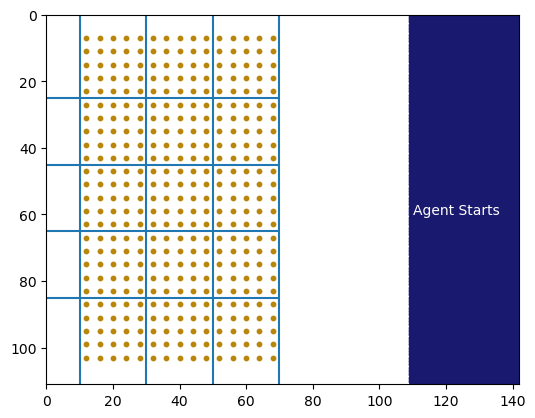

In [3]:
grid = np.zeros((111,142))

all_indices = np.array(list(np.ndindex((111,142))))
all_indices = all_indices[all_indices[:,1] >= 110]

source_indices = np.array(list(np.ndindex((25,15))))
source_indices = (source_indices * 4) + np.array([7,12])

plt.imshow(grid, cmap='Greys')

plt.hlines([25,45,65,85], xmin=0, xmax=70)
plt.vlines([10,30,50,70], ymin=0, ymax=111)
plt.ylim(111,0)
plt.xlim(0,142)
plt.gca().annotate('Agent Starts', xy=(110,60), color='white')

plt.scatter(source_indices[:,1], source_indices[:,0], s=10, c='darkgoldenrod', label='Source positions')
plt.scatter(all_indices[:,1], all_indices[:,0], c='midnightblue')
# plt.legend(loc='upper right')

## Functions

In [4]:
def read_folder(folder: str):
    # Reading files
    files = [file for file in os.listdir(folder) if 'analysis' in file]

    source_positions = np.array([[int(file.split('-')[0].split('_')[2]),int(file.split('-')[0].split('_')[3])] for file in files])

    dfs = [pd.read_csv(folder + f'source_pos_{pos[0]}_{pos[1]}-analysis.csv', index_col=0) for pos in source_positions]
    convergences = np.array([float(df['converged']['mean']) for df in dfs])
    steps_taken = np.array([float(df['steps_taken']['success_mean']) for df in dfs])


    # Building grids
    edges_vert = [0,25,45,65,85,111]
    edges_hori = [0,30,50,70]

    cells_shape = ((len(edges_vert)-1, len(edges_hori)-1))

    cells_indices = np.array(list(np.ndindex(cells_shape)))
    cells_ids = np.ravel_multi_index(cells_indices.T, cells_shape)

    vert_cells = np.argwhere((source_positions[:,1][:,None] >= edges_vert[:-1]) & (source_positions[:,1][:,None] < edges_vert[1:]))
    hori_cells = np.argwhere((source_positions[:,0][:,None] >= edges_hori[:-1]) & (source_positions[:,0][:,None] < edges_hori[1:]))

    source_cells = np.vstack([vert_cells[:,1], hori_cells[:,1]]).T

    grid_convergences = np.zeros(cells_shape)
    grid_steps_taken = np.zeros(cells_shape)

    for cell in cells_indices:
        in_cell = np.all(source_cells == cell, axis=1)
        grid_convergences[cell[0], cell[1]] = np.average(convergences[in_cell])
        grid_steps_taken[cell[0], cell[1]] = np.average(steps_taken[in_cell])
        if np.isnan(grid_steps_taken[cell[0], cell[1]]):
            grid_steps_taken[cell[0], cell[1]] = 1000

    return grid_convergences, grid_steps_taken

In [12]:
def get_histories(folder: str):
    files = [file for file in os.listdir(folder) if 'analysis' in file]
    source_positions = np.array([[int(file.split('-')[0].split('_')[2]),int(file.split('-')[0].split('_')[3])] for file in files])

    min_pos = np.min(source_positions, axis=0)
    min_pos_hist = SimulationHistory.load_from_file(folder + f'source_pos_{min_pos[0]}_{min_pos[1]}.csv')

    max_pos = np.max(source_positions, axis=0)
    max_pos_hist = SimulationHistory.load_from_file(folder + f'source_pos_{max_pos[0]}_{max_pos[1]}.csv')

    return min_pos_hist, max_pos_hist

In [25]:
def plot_results(folder, name):
    grid_convergences, grid_steps_taken = read_folder(folder)
    min_pos_hist, max_pos_hist = get_histories(folder)

    fig, axes = plt.subplots(nrows=2,
                            ncols=2,
                            figsize=(10,10),
                            #  gridspec_kw={'wspace':0.4}
                            )
    fig.suptitle(name)

    # Plot convergence map
    conv_ax = axes[0,0]
    conv_ax.set_title(f'Convergence')
    conv_im = conv_ax.imshow(grid_convergences, cmap='RdYlGn', vmax=1, vmin=0)
    fig.colorbar(conv_im, ax=conv_ax)

    # Plot steps taken map
    step_ax = axes[0,1]
    step_ax.set_title(f'Steps Taken')
    step_im = step_ax.imshow(grid_steps_taken, cmap='RdYlGn_r')
    fig.colorbar(step_im, ax=step_ax)

    # Source positions
    files = [file for file in os.listdir(folder) if 'analysis' in file]
    source_positions = np.array([[int(file.split('-')[0].split('_')[2]),int(file.split('-')[0].split('_')[3])] for file in files])
    min_pos = np.min(source_positions, axis=0)
    max_pos = np.min(source_positions, axis=0)

    # Plot path with min source
    min_path_ax = axes[1,0]
    min_path_ax.set_title(f'Trajectory 0 - Source [{min_pos[0]}, {min_pos[1]}]')
    min_pos_hist.plot(ax=min_path_ax)

    # Plot path with max source
    max_path_ax = axes[1,1]
    max_path_ax.set_title(f'Trajectory 0 - Source [{max_pos[0]}, {max_pos[1]}]')
    max_pos_hist.plot(ax=max_path_ax)

## Cov 5 - results

### Trained: cov 5

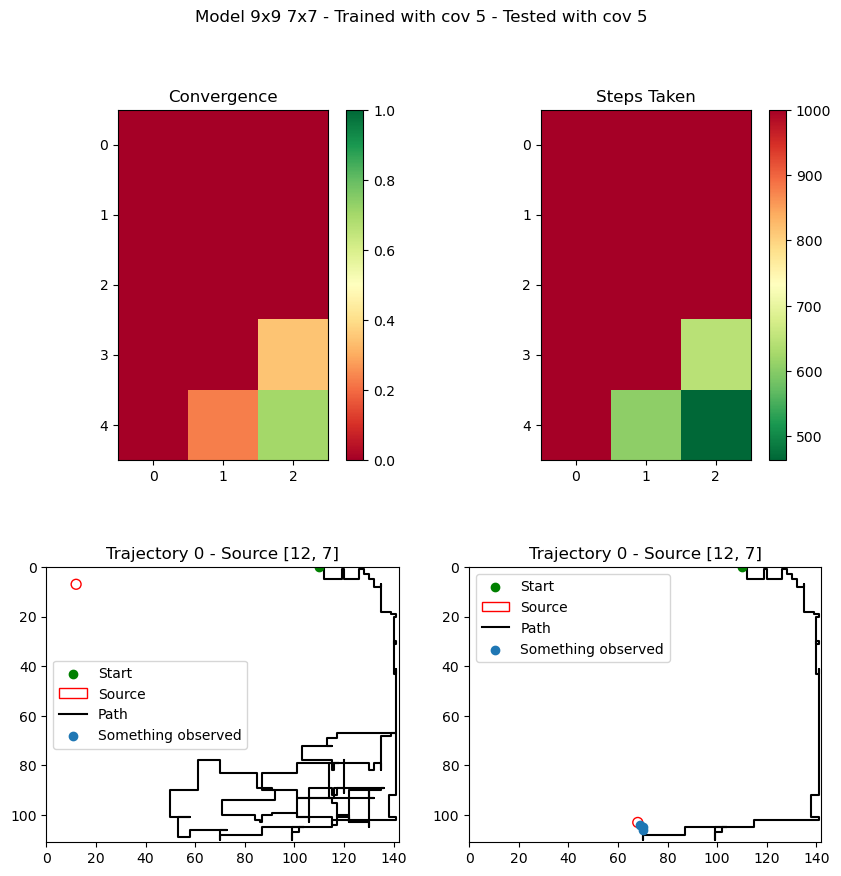

In [26]:
folder = '/storage/arnaud/test_cov_artif/cov_test-9_9-7_7-cov_5/'
name = 'Model 9x9 7x7 - Trained with cov 5 - Tested with cov 5'
plot_results(folder, name)

### Trained: cov 10

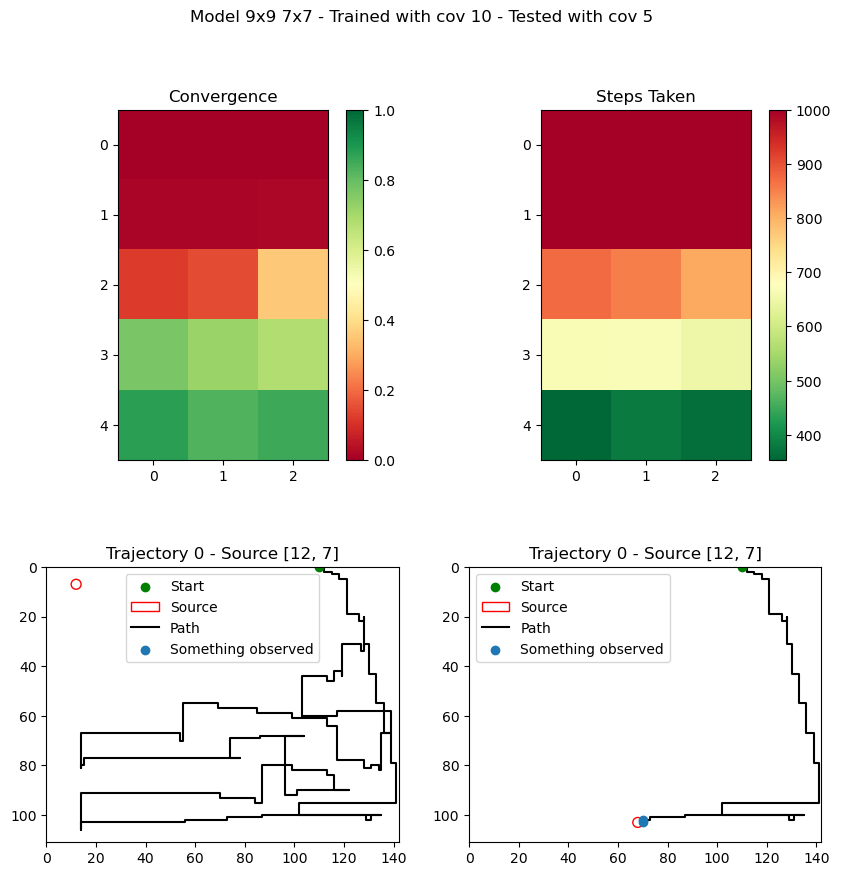

In [31]:
folder = '/storage/arnaud/test_cov_artif/cov_test-9_9-7_7-cov_10/'
name = 'Model 9x9 7x7 - Trained with cov 10 - Tested with cov 5'
plot_results(folder, name)

### Trained: cov 25

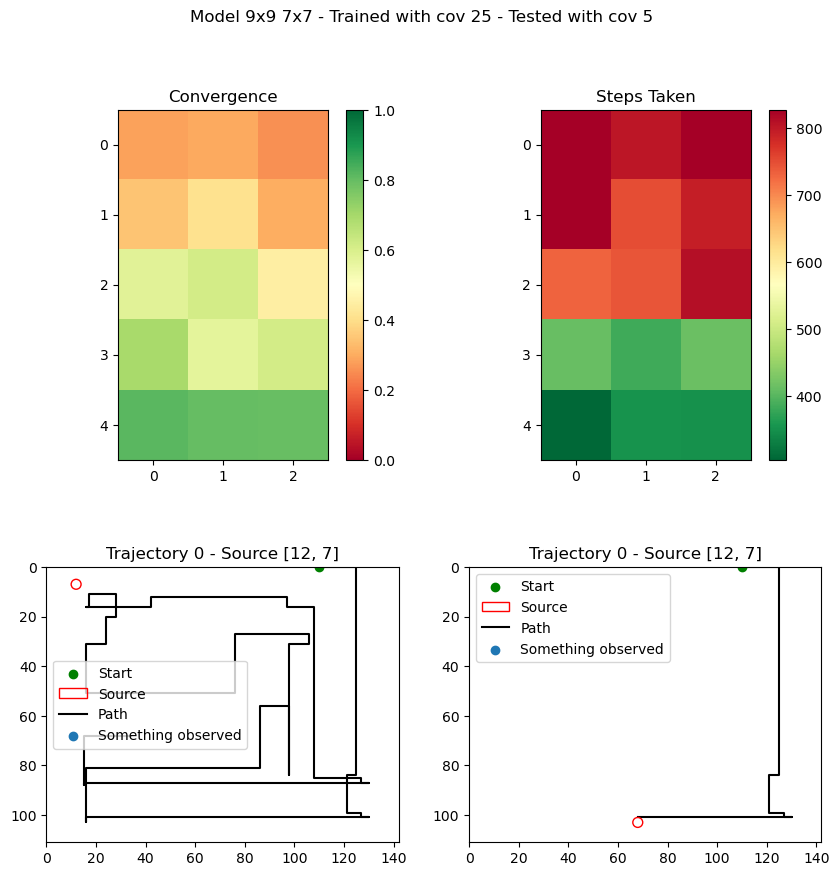

In [32]:
folder = '/storage/arnaud/test_cov_artif/cov_test-9_9-7_7-cov_25/'
name = 'Model 9x9 7x7 - Trained with cov 25 - Tested with cov 5'
plot_results(folder, name)

### Trained: cov 50

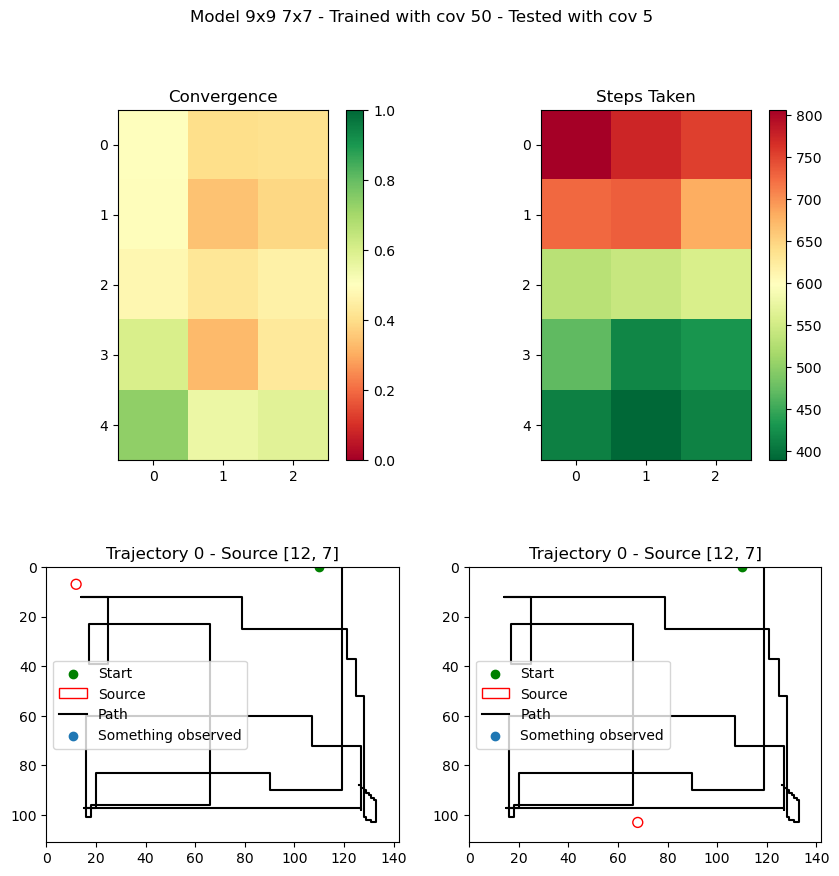

In [33]:
folder = '/storage/arnaud/test_cov_artif/cov_test-9_9-7_7-cov_50/'
name = 'Model 9x9 7x7 - Trained with cov 50 - Tested with cov 5'
plot_results(folder, name)

## Cov 10 - results

### Trained: cov 5

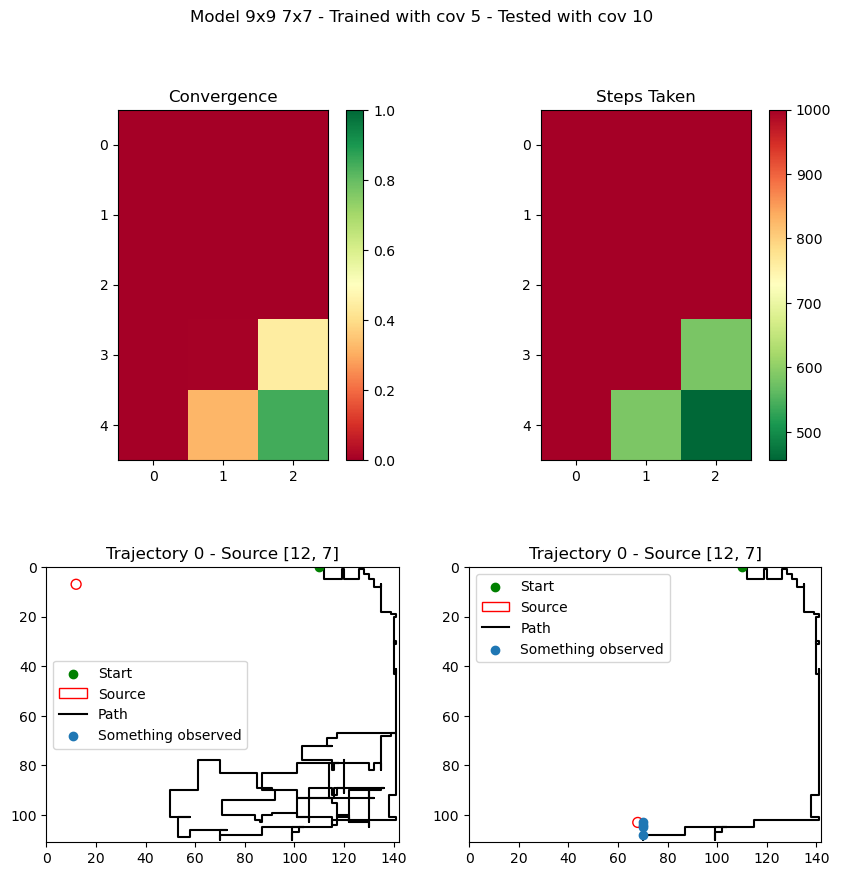

In [30]:
folder = '/storage/arnaud/test_cov_artif/cov_test-9_9-tcov_10-7_7-cov_5/'
name = 'Model 9x9 7x7 - Trained with cov 5 - Tested with cov 10'
plot_results(folder, name)

### Trained: cov 10

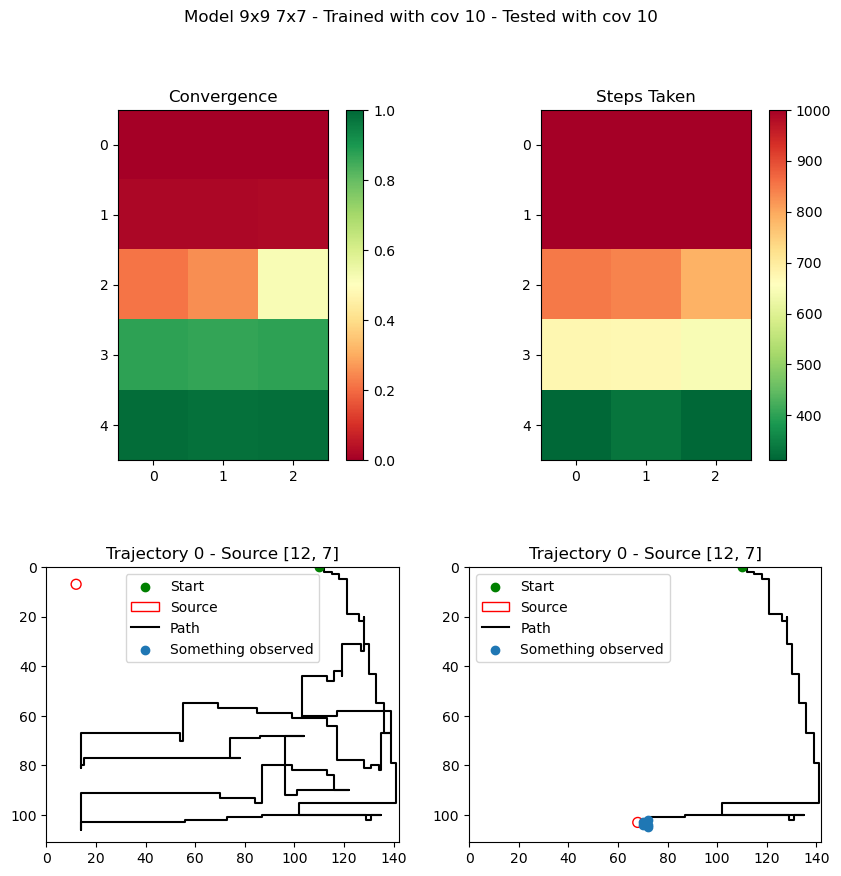

In [34]:
folder = '/storage/arnaud/test_cov_artif/cov_test-9_9-tcov_10-7_7-cov_10/'
name = 'Model 9x9 7x7 - Trained with cov 10 - Tested with cov 10'
plot_results(folder, name)

### Trained: cov 25

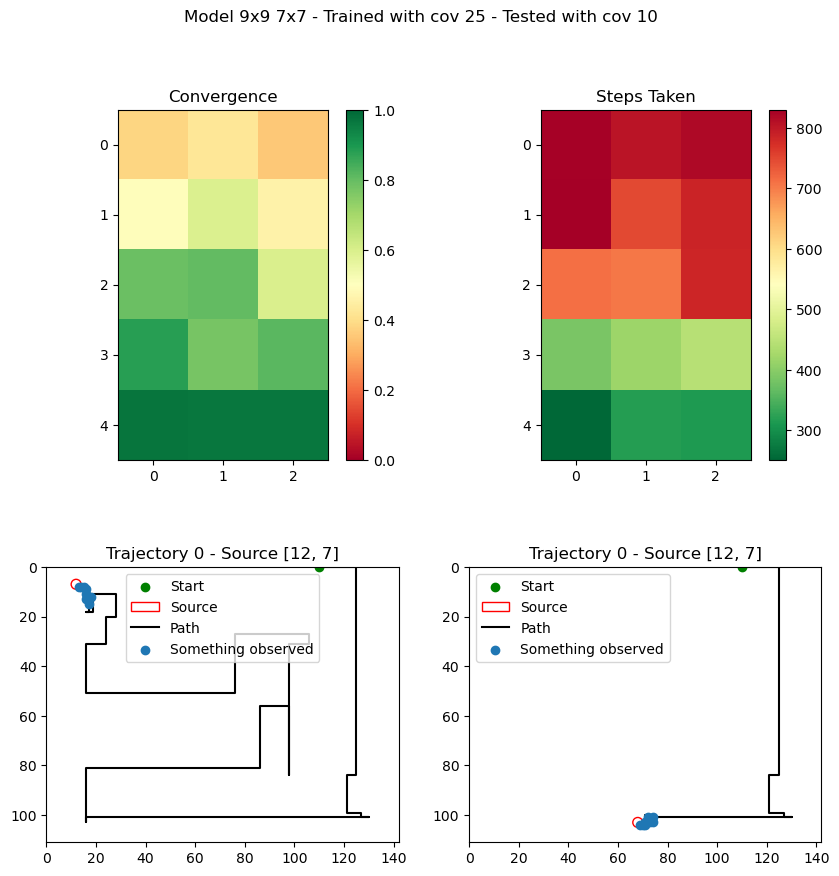

In [35]:
folder = '/storage/arnaud/test_cov_artif/cov_test-9_9-tcov_10-7_7-cov_25/'
name = 'Model 9x9 7x7 - Trained with cov 25 - Tested with cov 10'
plot_results(folder, name)

### Trained: cov 50

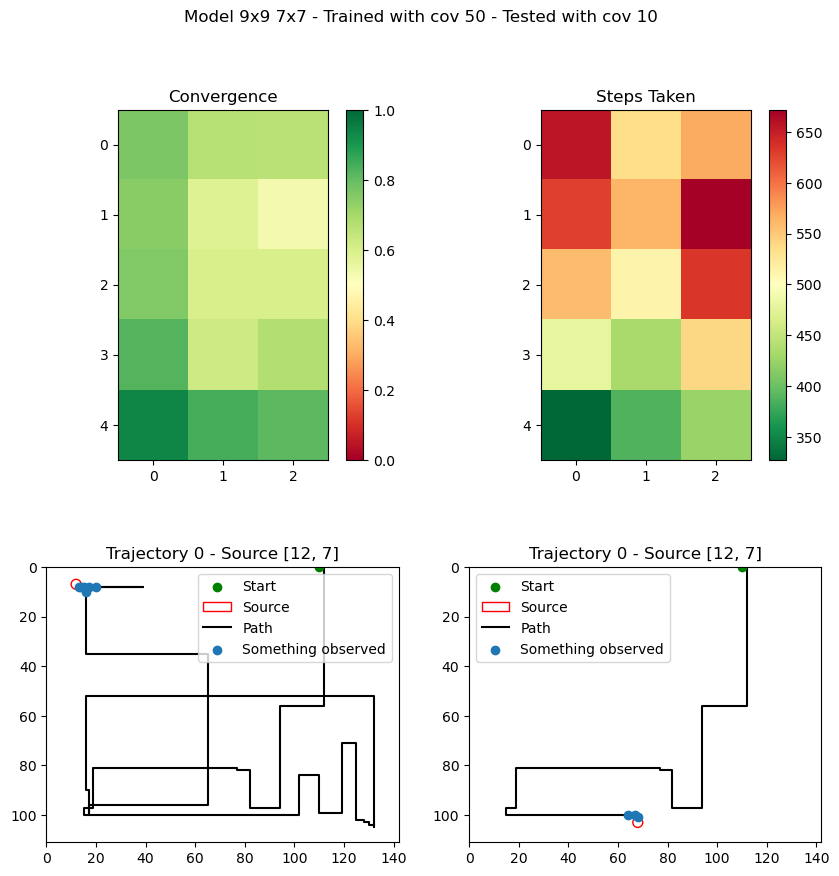

In [36]:
folder = '/storage/arnaud/test_cov_artif/cov_test-9_9-tcov_10-7_7-cov_50/'
name = 'Model 9x9 7x7 - Trained with cov 50 - Tested with cov 10'
plot_results(folder, name)

## Uniform radius 5 - results

### Trained: cov 5

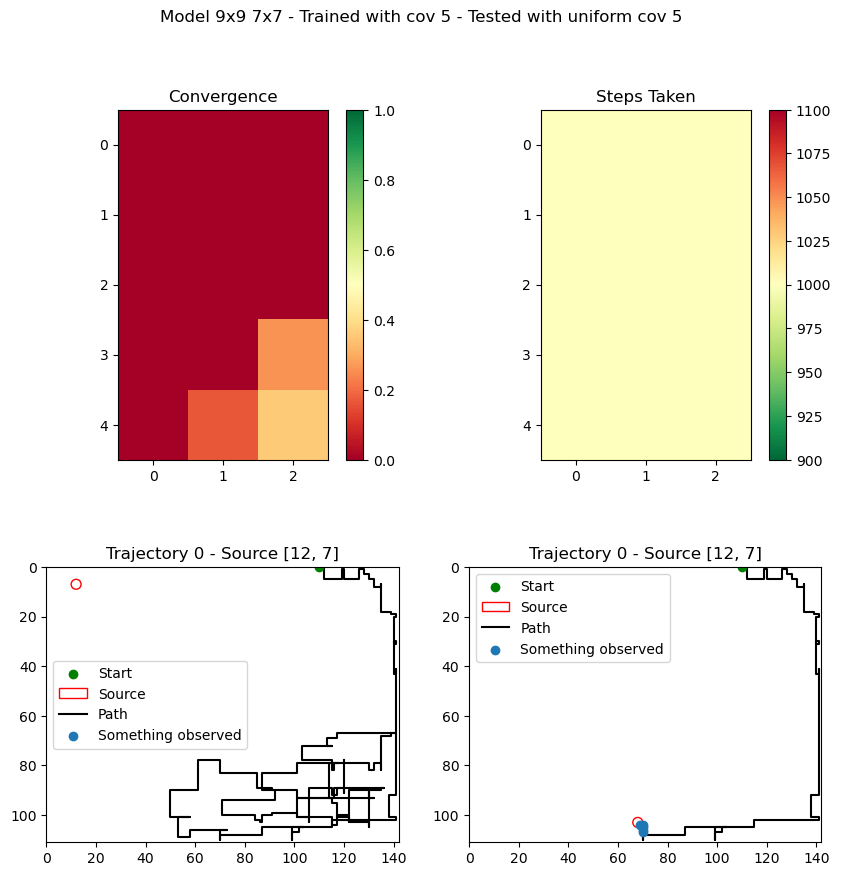

In [39]:
folder = '/storage/arnaud/test_cov_artif_uniform/cov_test-9_9-uniform_rad_5-7_7-cov_5/'
name = 'Model 9x9 7x7 - Trained with cov 5 - Tested with uniform cov 5'
plot_results(folder, name)

### Trained: cov 10

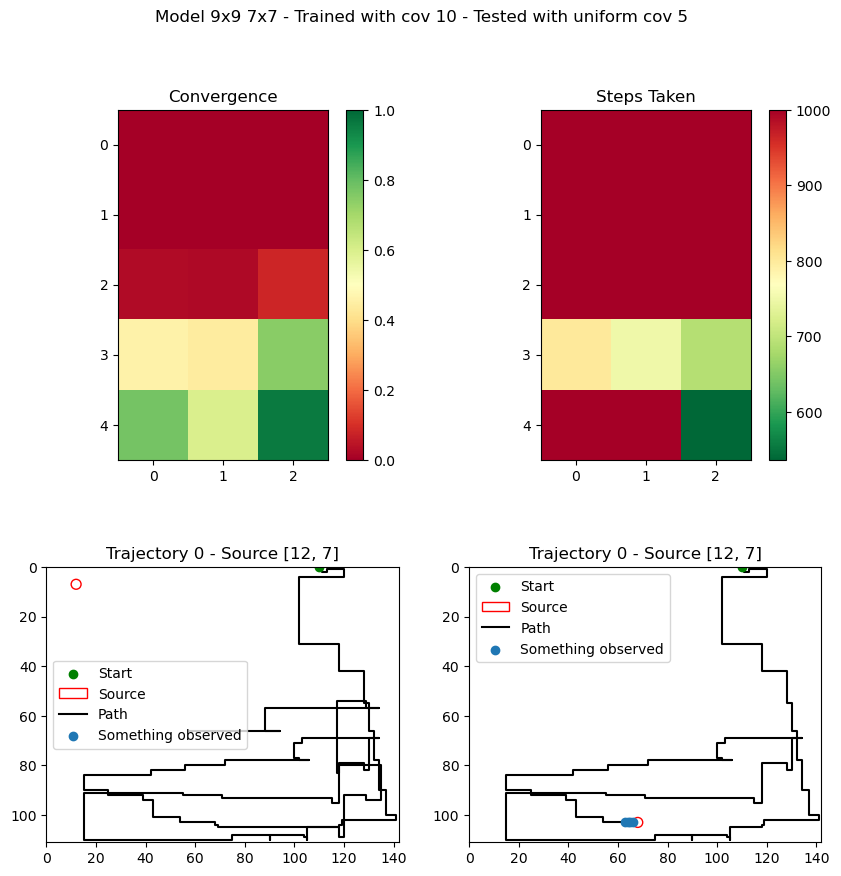

In [40]:
folder = '/storage/arnaud/test_cov_artif_uniform/cov_test-9_9-uniform_rad_5-7_7-cov_10/'
name = 'Model 9x9 7x7 - Trained with cov 10 - Tested with uniform cov 5'
plot_results(folder, name)

### Trained: cov 25

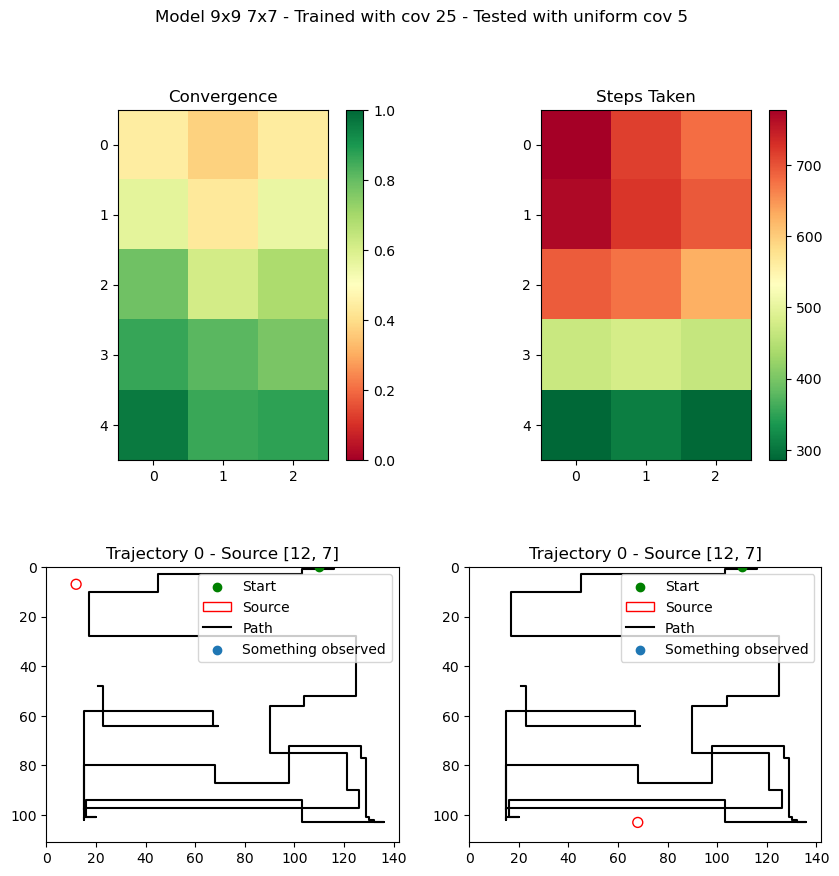

In [41]:
folder = '/storage/arnaud/test_cov_artif_uniform/cov_test-9_9-uniform_rad_5-7_7-cov_25/'
name = 'Model 9x9 7x7 - Trained with cov 25 - Tested with uniform cov 5'
plot_results(folder, name)

### Trained: cov 50

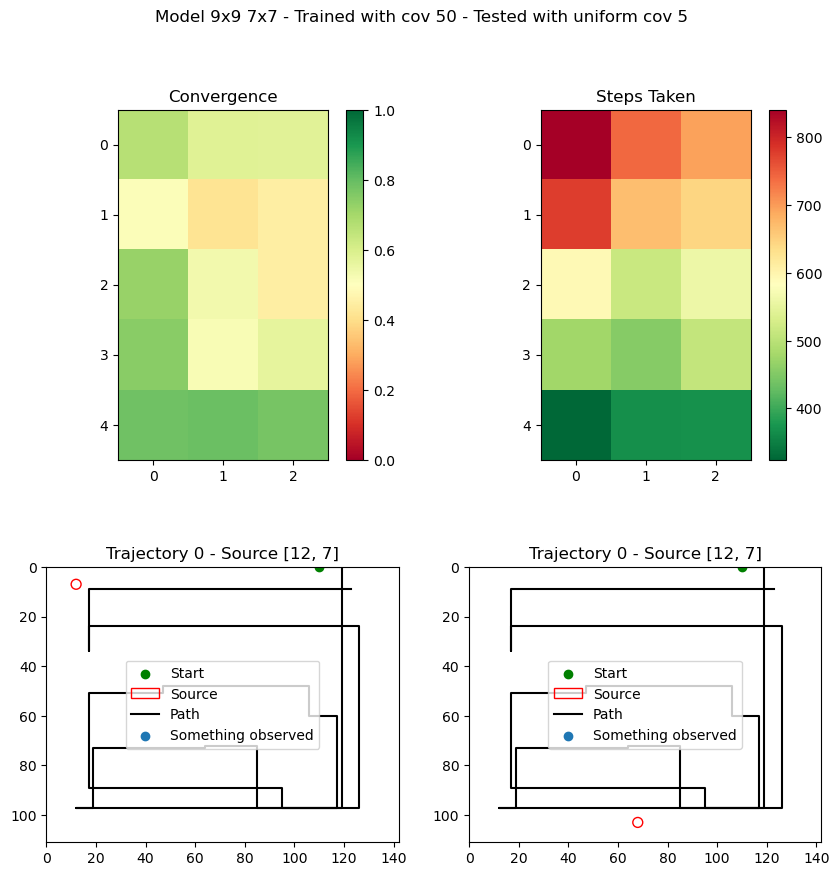

In [42]:
folder = '/storage/arnaud/test_cov_artif_uniform/cov_test-9_9-uniform_rad_5-7_7-cov_50/'
name = 'Model 9x9 7x7 - Trained with cov 50 - Tested with uniform cov 5'
plot_results(folder, name)